# **Stock Price Forecasting for n number of days**
***Author : Anoop Reddy Kallem***
<br><br>
This project is aimed towards to forecasting stock prices of a company for n steps(days) into the future depending on the status of the company in the market(daily news). In this project, I have taken stock prices of AAPL from Jan 2010 to June 2022. Note that this is not a regular "`train_test_split()`" everybody uses for their Supervised Learning models. This model uses Sliding Window Technique since this data is in time-series format.
<br><br>
After successfully apply Sliding Window to the data, an input "`num_days`" is taken from the end user. Note that, its better to input a seemingly fair number like `30 or 15 or 7`, because the model is a little unstable to capture deep lying dependencies and sentiments. *Don't be greedy.* The input is ran through a function '`predict_future_prices()`' which predicts the prices for the specified number of days. In order to keep the model in touch with the ongoing market trends, I prepared another model that learns the sentiment of a given statement and classifies it as negative or positive or neutral. The same input is given to its corresponding date and its stock price. Finally, depending on the status of the news, a bias is imputed to the model externally which affects the price to either hike, fall or stay neutral.
<br><br>
I have faced some issues during imputation of stock exchange news to the forecasting model, hence I have used the "`np.random(num_days) * 2 - 1`" which generates random float points between `-1 and 1` and will be induced to the prices. Basically it is like a multiplier to a score. At the end, the predictions and actual prices are plotted and compared.

That is all about my project, I hope to research more on this aspect and find more easier and efficient way to forecast the stock prices even though stock market is very volatile and unpredictable.

Should you have any queries, feel free to contact me on "`kallemanoop@gmail.com`"

### install dependencies

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

2024-03-23 19:53:23.659885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 19:53:23.659983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 19:53:23.813400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### training sentiment analysis model for imputing sentiment scores to forecast model

In [4]:
data = pd.read_csv('/kaggle/input/stock/AAPLfull.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
close = data['close']

df = pd.read_csv('/kaggle/input/stock/extended_stock_market_news_dataset (1).csv')

train_data, test_data, train_labels, test_labels = train_test_split(
    df['headline'], df['label'], test_size=0.5, random_state=0
)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42
)


### preparing naive bayes classifier for sentiment analysis

In [5]:
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(train_data)
val_features = vectorizer.transform(val_data)
test_features = vectorizer.transform(test_data)

# naive bayes classifier
best_accuracy = 0
best_epoch = 0
best_model = None
patience = 5

for epoch in range(1, 101):
    model = MultinomialNB()
    model.fit(train_features, train_labels)

    #validation
    val_predictions = model.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    print(f'Epoch {epoch} - Validation Accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        best_model = model
    elif epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch}. No improvement in {patience} epochs.')
        break


Epoch 1 - Validation Accuracy: 1.0000
Epoch 2 - Validation Accuracy: 1.0000
Epoch 3 - Validation Accuracy: 1.0000
Epoch 4 - Validation Accuracy: 1.0000
Epoch 5 - Validation Accuracy: 1.0000
Epoch 6 - Validation Accuracy: 1.0000
Early stopping at epoch 6. No improvement in 5 epochs.


### 1. predict sentiment score
### 2. assign the same predicted scores to dates and their corresponding stock prices

In [6]:
# Predict sentiment scores
train_sentiment_scores = best_model.predict(train_features)
val_sentiment_scores = best_model.predict(val_features)
test_sentiment_scores = best_model.predict(test_features)

# Combine sentiment scores with dates
train_sentiment_data = pd.DataFrame({'date': train_data.index, 'sentiment_score': train_sentiment_scores})
val_sentiment_data = pd.DataFrame({'date': val_data.index, 'sentiment_score': val_sentiment_scores})
test_sentiment_data = pd.DataFrame({'date': test_data.index, 'sentiment_score': test_sentiment_scores})

train_sentiment_data['date'] = pd.to_datetime(train_sentiment_data['date'])
val_sentiment_data['date'] = pd.to_datetime(val_sentiment_data['date'])
test_sentiment_data['date'] = pd.to_datetime(test_sentiment_data['date'])

#merge data and sentiment scores
data_with_sentiment_train = pd.merge(data, train_sentiment_data, on='date', how='left')
data_with_sentiment_val = pd.merge(data, val_sentiment_data, on='date', how='left')
data_with_sentiment_test = pd.merge(data, test_sentiment_data, on='date', how='left')

data_with_sentiment_train['sentiment_score'].fillna(0, inplace=True)
data_with_sentiment_val['sentiment_score'].fillna(0, inplace=True)
data_with_sentiment_test['sentiment_score'].fillna(0, inplace=True)

data_with_sentiment_train['close_adjusted'] = data_with_sentiment_train['close'] * (1 + data_with_sentiment_train['sentiment_score'])
data_with_sentiment_val['close_adjusted'] = data_with_sentiment_val['close'] * (1 + data_with_sentiment_val['sentiment_score'])
data_with_sentiment_test['close_adjusted'] = data_with_sentiment_test['close'] * (1 + data_with_sentiment_test['sentiment_score'])


/tmp/ipykernel_34/3414661169.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_with_sentiment_train['sentiment_score'].fillna(0, inplace=True)
/tmp/ipykernel_34/3414661169.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_with_sentiment_train['sentiment_score'].fillna(0, inplace=True)
/tmp/ipyke

create train, test and val sets. data is scaled here.

In [7]:
# Modify features based on your requirement, here we include 'close_adjusted'
features_train = data_with_sentiment_train[['close_adjusted']].values
features_val = data_with_sentiment_val[['close_adjusted']].values
features_test = data_with_sentiment_test[['close_adjusted']].values

target_train = data_with_sentiment_train['close'].values
target_val = data_with_sentiment_val['close'].values
target_test = data_with_sentiment_test['close'].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features_train = scaler.fit_transform(features_train)
scaled_features_val = scaler.transform(features_val)
scaled_features_test = scaler.transform(features_test)

scaled_target_train = scaler.fit_transform(target_train.reshape(-1, 1))
scaled_target_val = scaler.transform(target_val.reshape(-1, 1))
scaled_target_test = scaler.transform(target_test.reshape(-1, 1))


### sliding window technqiue

In [8]:
# sliding window technique
def create_dataset(dataset, target, time_step):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        X.append(a)
        Y.append(target[i + time_step])
    return np.array(X), np.array(Y)


### declare sliding window time step (you can opt for any number, just make it look reasonable, not stupid)

In [9]:
# Define parameters
time_step = 200
n_features = scaled_features_train.shape[1]

X_train, y_train = create_dataset(scaled_features_train, scaled_target_train, time_step)
X_val, y_val = create_dataset(scaled_features_val, scaled_target_val, time_step)
X_test, y_test = create_dataset(scaled_features_test, scaled_target_test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], n_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)


### building lstm neural network

In [21]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, n_features)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0180 - val_loss: 5.1166e-04
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.9505e-04 - val_loss: 4.2505e-04
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8215e-04 - val_loss: 4.9835e-04
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0373e-04 - val_loss: 5.2645e-04
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.8276e-04 - val_loss: 2.8055e-04
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.5423e-04 - val_loss: 2.7522e-04
Epoch 7/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.5909e-04 - val_loss: 2.6254e-04
Epoch 8/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.4556e-04 - val_loss: 2.6852e-04
Epoch 9/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.6477e-04 - val_loss: 3.1202e-04
Epoch 10/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.2158e-04 - val_loss: 1.9834e-04
Epoch 11/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.2324e-04 - v

### predicting over known data to verify working model

In [22]:
# Predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
val_predict = scaler.inverse_transform(val_predict)
test_predict = scaler.inverse_transform(test_predict)



92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


### plotting the predictions from above

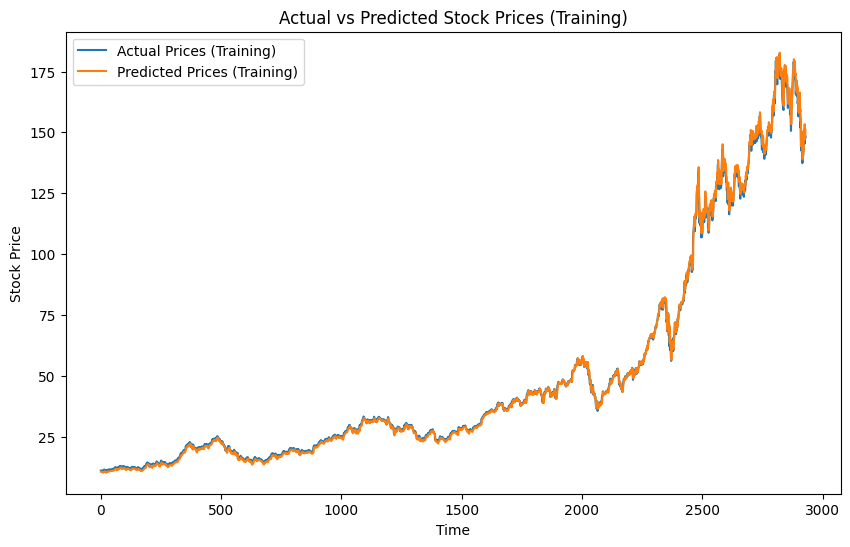

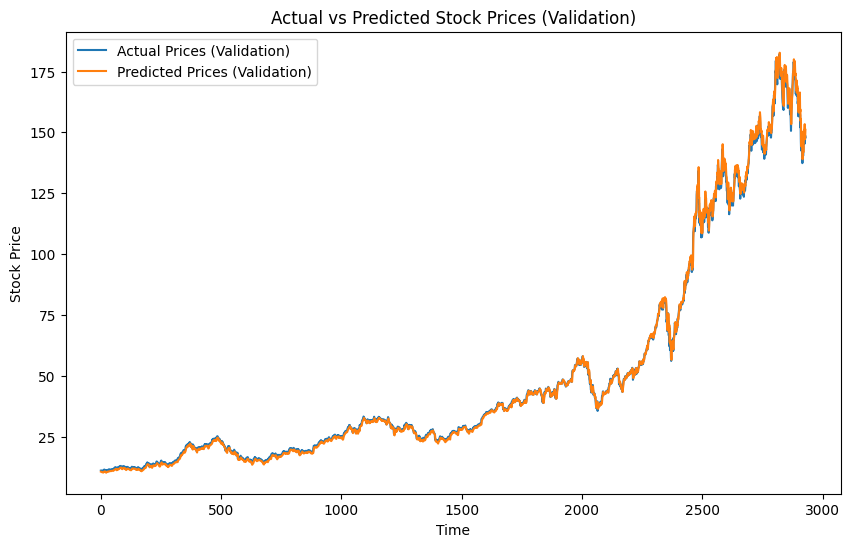

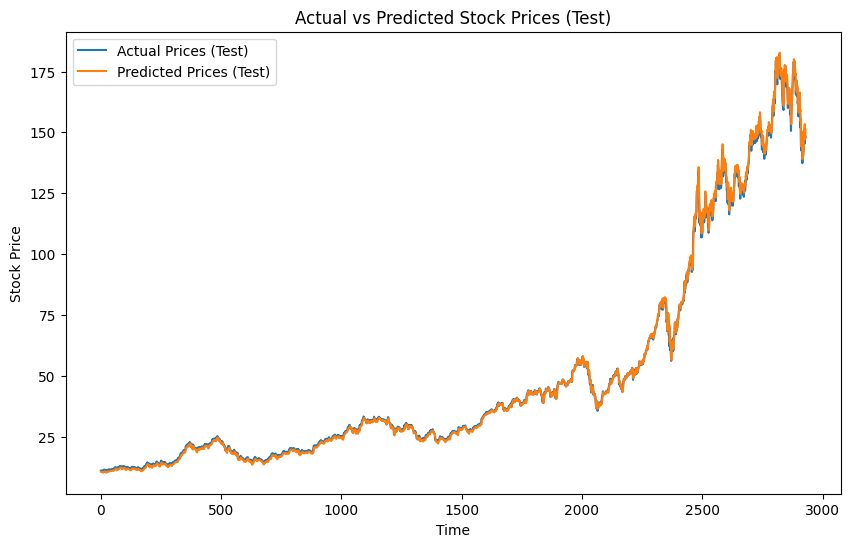

In [23]:
actual_train_prices = scaler.inverse_transform(y_train.reshape(-1, 1))
actual_val_prices = scaler.inverse_transform(y_val.reshape(-1, 1))
actual_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actual_train_prices, label='Actual Prices (Training)')
plt.plot(train_predict, label='Predicted Prices (Training)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Training)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(actual_val_prices, label='Actual Prices (Validation)')
plt.plot(val_predict, label='Predicted Prices (Validation)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Validation)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(actual_test_prices, label='Actual Prices (Test)')
plt.plot(test_predict, label='Predicted Prices (Test)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices (Test)')
plt.legend()
plt.show()


### creating a function that predicts prices of n steps/days by taking last_known_prices which is basically` [len(dataset) - your time step]` and the sentiment scores.

In [24]:
def predict_future_prices(model, last_known_prices, num_days, sentiment_scores):
    future_prices = []
    last_known_prices_scaled = scaler.transform(last_known_prices.reshape(-1, 1))
    sentiment_scores_scaled = scaler.transform(sentiment_scores.reshape(-1, 1))

    for i in range(num_days):
        X = np.array(last_known_prices_scaled[-time_step:]).reshape(1, time_step, n_features)
        sentiment_scores_repeat = np.repeat(sentiment_scores_scaled[-1:], time_step, axis=0)
        X_adjusted = X * (1 + sentiment_scores_repeat)
        predicted_price_scaled = model.predict(X)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        future_prices.append(predicted_price[0][0])
        last_known_prices_scaled = np.append(last_known_prices_scaled, predicted_price_scaled)

    return future_prices


### generating random 30 float points between -1 and 1 as bias.

In [25]:
last_known_prices = close.values[-time_step:]

sentiment_scores = np.random.rand(30) * 2 - 1

num_days = 30
future_prices = predict_future_prices(model, last_known_prices, num_days, sentiment_scores)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

### plot the absurdity that we just created

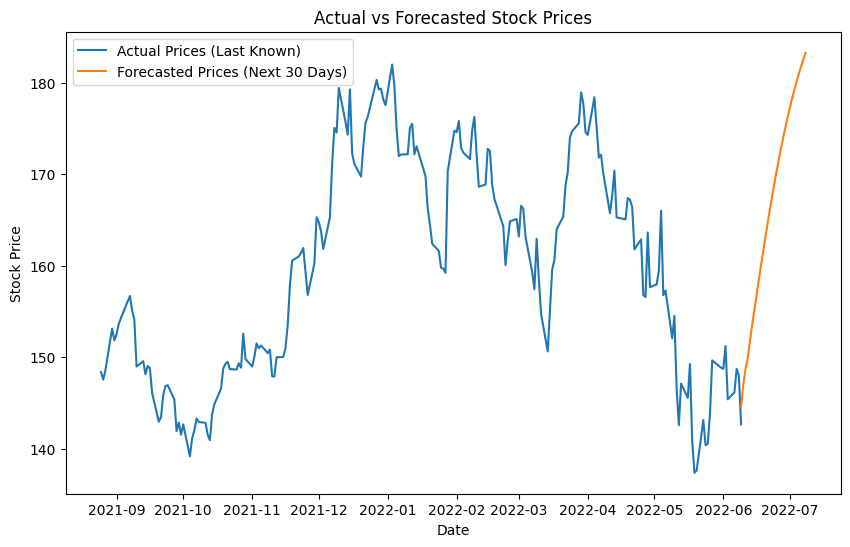

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(close.index[-time_step:], close.values[-time_step:], label='Actual Prices (Last Known)')
plt.plot(pd.date_range(start=close.index[-1], periods=num_days), future_prices, label='Forecasted Prices (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Forecasted Stock Prices')
plt.legend()
plt.show()